Name: Saman Akhtar USC ID: 9944619932

**Imports**

In [561]:
from sklearn import neighbors, metrics, preprocessing as pre
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import statsmodels.api as stat
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from matplotlib.cbook import boxplot_stats  

## Load Data from sheet 1 of Power Plant data

In [562]:
ccpp_df = pd.read_excel("../../data/CCPP/Folds5x2_pp.xlsx", sheet_name = 0)
ccpp_df


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


## Exploring the data: 

### i. How many rows are in this data set? How many columns? What do the rows and columns represent? 

In [563]:
ccpp_df.shape

(9568, 5)

There are 9568 rows and 5 columns in this dataset.

In [564]:
ccpp_df.columns

Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')

Each row represents hourly average values for the columns mentioned below.
The four columns: Ambient Temperature(AT), Exhaust Vacuum(V),Ambient Pressure(AP), Relative Humidity(RH)
are features or independent variable.
The fifth column Energy output(PE) is label or dependent variable. It represents the net hourly electrical energy output.
Also Exhaust Vacuum(V) has effect on the Steam Turbine, while Ambient Temperature(AT),Ambient Pressure(AP), Relative Humidity(RH) effect the Gas Turbines performance.



In [565]:
df = ccpp_df.copy()

### ii. Make pairwise scatterplots of all the varianbles in the data set including the predictors (independent variables) with the dependent variable. Describe yourfindings.

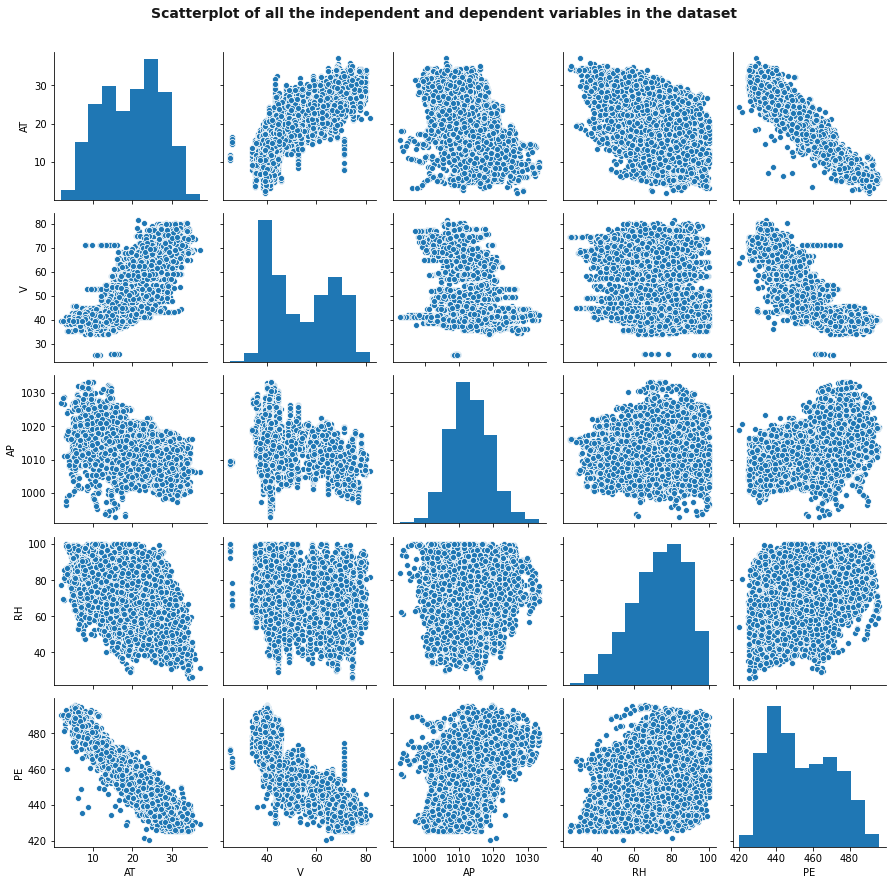

In [566]:
plots = sns.pairplot(df)
plt.tight_layout()
plt.subplots_adjust(top = .93 )
plots.fig.suptitle("Scatterplot of all the independent and dependent variables in the dataset ", fontsize = 14, alpha = 0.9, weight = 'bold')
plt.show()

From the above scatterplot following deduction can be made
1) AT: AT has positive linear relation with V. While with PE, AT has a negative correlation.
2) V: has positive linear relation with AT. And negative relation with PE
3) AP and RH doesn't have any linear relation with other independent variable. They are spread across the values
4) PE: It is spread across with AP and RH. But it has weak postive relation with AP and RH. Unlike AT and V, where PE has strong negative relation.

In [567]:
corr, _ = pearsonr(df.AT,df.V)
print("Pearsons correlation:",corr)

Pearsons correlation: 0.844106731867867


This shows strong postive correlation between AT and V. During fitting of model with various data set, there can be large variation in estimation of coefficient because of this strong postive correlation between AT and V.

In [568]:
corr, _ = pearsonr(df.AT,df.PE)
print("Pearsons correlation of AT and PE:",corr)
corr, _ = pearsonr(df.V,df.PE)
print("Pearsons correlation of V and PE:",corr)

Pearsons correlation of AT and PE: -0.9481284704167594
Pearsons correlation of V and PE: -0.8697803096577881


Shows negative correlatiob between AT and PE , and V and PE.

### iii. What are the mean, the median, range, first and third quartiles, and in- terquartile ranges of each of the variables in the dataset? Summarize them in a table. 

In [569]:
# Calculate each stats and store it in a list
mean = [np.mean(df[col]) for col in df.columns]
median = [np.median(df[col]) for col in df.columns]
std = [np.std(df[col]) for col in df.columns]
range_stat = [df[col].max() - df[col].min() for col in df.columns]
firstQ = [np.percentile(df[col], 25) for col in df.columns]
thirdQ = [np.percentile(df[col], 75) for col in df.columns]
IQR = list(np.array(thirdQ)-np.array(firstQ))


In [570]:
# Create dictionary for all the stats
stats = pd.DataFrame(
    {'mean': mean,
     'median': median,
     'std' : std,
     'range': range_stat,
     'first-Quartiles' : firstQ,
     'second-Quartiles' : thirdQ,
     'in-terquartile' : IQR
    }, df.columns)

stats

,mean,median,std,range,first-Quartiles,second-Quartiles,in-terquartile
AT,19.651231,20.345,7.452084,35.30,13.5100,25.72,12.2100
V,54.305804,52.080,12.707229,56.20,41.7400,66.54,24.8000
AP,1013.259078,1012.940,5.938473,40.41,1009.1000,1017.26,8.1600
RH,73.308978,74.975,14.599506,74.60,63.3275,84.83,21.5025
PE,454.365009,451.550,17.066103,75.50,439.7500,468.43,28.6800


## (c) For each predictor, fit a simple linear regression model to predict the response. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions. Are there any outliers that you would like to remove from your data for each of these regression tasks? 

Spliting data

In [571]:
X_train = df.loc[:, df.columns != 'PE']
y_train = df[['PE']]

In [572]:
# Function to train, fit and predict the model using statsmodel
def fit_Predict(col_name, X = X_train, Y = y_train):
    X = stat.add_constant(X)
    model = stat.OLS(Y,X)
    
    # Fit using statsmodel
    fits = model.fit()
    pred = fits.predict(X) 
    print("Summary of column: ", col_name, " and PE is:\n" , fits.summary())
    r2 = r2_score(Y, pred)
    return fits, pred, fits.pvalues, r2

##### For predictor AT

In [573]:
AT_train = X_train[['AT']]
AT_fits, AT_pred, AT_pval, AT_r2 = fit_Predict('AT',AT_train)
print(" Predicted value with respect to column AT is:\n", AT_pred )

Summary of column:  AT  and PE is:
                             OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Tue, 15 Jun 2021   Prob (F-statistic):               0.00
Time:                        00:20:00   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        497

Get p value for the independent variable:
This is done to know whether there is a statistically significant
association between the predictor and the response.
A p-value of less than 0.05 is considered to be statistically significant

In [574]:
AT_pval[1]

0.0

P value is 0.0 . This is less than 0.05. Thus the null hypothesis is rejected. Which means that 'AT' has a statistically significant association with 'PE'.

 Evaluating the model performance of the regression model

I will use R sqaure value.
R Square value is between 0 to 1. More it is close to 1, the better it fits between prediction and actual value.

In [575]:
AT_r2

0.8989475964148236

In theory Mean Squared error or Root Mean Square Error metric is 0.0. But in reality, it is not possible to get 0. So lower the MSE/RMSE value the better the performance of model

In [576]:
mse = mean_squared_error(y_train, AT_pred)
AT_rmse= math.sqrt(mse)
AT_rmse

5.4250992627871355

For the predictor AT, we got lower RMSE value and R2 score closer to 1. This shows accuracy of model is good.

Scatter plot

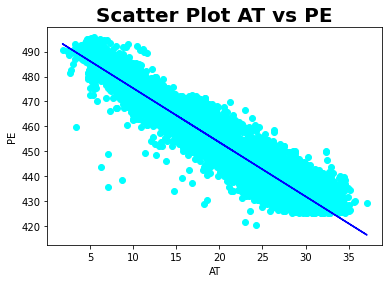

In [577]:
plt.scatter(AT_train,y_train ,color='cyan')
plt.plot(AT_train,AT_pred,color='blue')
plt.xlabel('AT')
plt.ylabel('PE')
plt.title('Scatter Plot AT vs PE', fontsize = 20, weight = 'bold')
plt.show()

The scatterplot shows negative correlation between AT an PE. Also this backs accuracy and significance of association.

To find outlier, I will use boxplot

Text(0.5, 0, 'AT')

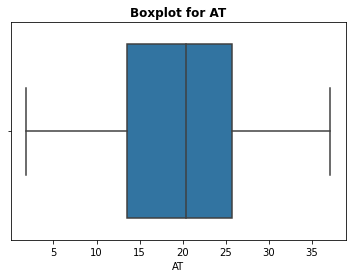

In [578]:
bplot = sns.boxplot(x=AT_train)
bplot.set_title("Boxplot for AT", weight = 'bold')
bplot.set_xlabel('AT')

From this boxplot it is deduced that there are no outliers which should be removed from the regression of  AT and PE.


In [579]:
boxplot_stats(AT_train).pop(0)['fliers']

array([], dtype=float64)

##### For predictor V

In [580]:
V_train = X_train['V']
V_fits, V_pred, V_pval, V_r2 = fit_Predict('V',V_train)
print(" Predicted value with respect to column V is:\n", V_pred )

Summary of column:  V  and PE is:
                             OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 2.972e+04
Date:                Tue, 15 Jun 2021   Prob (F-statistic):               0.00
Time:                        00:20:03   Log-Likelihood:                -33963.
No. Observations:                9568   AIC:                         6.793e+04
Df Residuals:                    9566   BIC:                         6.794e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        517.

Get p value for the independent variable:
This is done to know whether there is a statistically significant
association between the predictor and the response.
A p-value of less than 0.05 is considered to be statistically significant

In [581]:
V_pval[1]

0.0

P value is 0.0 which is less than 0.05. Thus similar to AT, here also the null hypothesis is rejected. Which means that 'V' has a statistically significant association with 'PE'.

 Evaluating the model performance of the regression model

In [582]:
V_r2

0.7565177870683979

In [583]:
mse = mean_squared_error(y_train, V_pred)
V_rmse= math.sqrt(mse)
V_rmse

8.421083720649515

For the predictor V, we got lower RMSE value and R2 score closer to 1. This shows accuracy of model is good. 
But from the R squared score and Root mean squared error score, we can infer AT model fits better than V model 

Scatter plot for V

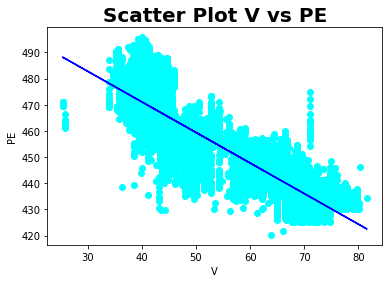

In [584]:
plt.scatter(V_train,y_train ,color='cyan')
plt.plot(V_train,V_pred,color='blue')
plt.xlabel('V')
plt.ylabel('PE')
plt.title('Scatter Plot V vs PE', fontsize = 20, weight = 'bold')
plt.show()

The scatterplot shows negative correlation between V an PE. But it is not strong as compared to the correlation between AT and PE.
Also this backs accuracy and significance of association.

Boxplot for V

Text(0.5, 0, 'V')

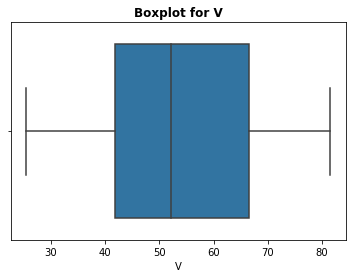

In [585]:
bplt = sns.boxplot(x = V_train)
bplt.set_title("Boxplot for V", weight = 'bold')
bplt.set_xlabel('V')

From this boxplot it is deduced that there are no outliers which should be removed from the regression of  V and PE.


In [586]:
boxplot_stats(V_train).pop(0)['fliers']

array([], dtype=float64)

##### For predictor AP (Ambient Pressure)

In [587]:
AP_train = X_train['AP']
AP_fits, AP_pred, AP_pval, AP_r2 = fit_Predict('AP',AP_train)
print(" Predicted value with respect to the column AP(Ambient Pressure) is:\n", AP_pred )

Summary of column:  AP  and PE is:
                             OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     3516.
Date:                Tue, 15 Jun 2021   Prob (F-statistic):               0.00
Time:                        00:20:04   Log-Likelihood:                -39224.
No. Observations:                9568   AIC:                         7.845e+04
Df Residuals:                    9566   BIC:                         7.847e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1055

Get p value for the independent variable:
This is done to know whether there is a statistically significant
association between the predictor and the response.
A p-value of less than 0.05 is considered to be statistically significant

In [588]:
AP_pval[1]

0.0

P value is 0.0 which is less than 0.05. Here also the null hypothesis is rejected. Hence AP has a statistically significant association with 'PE'.

 Evaluating the model performance of the regression model

In [589]:
AP_r2

0.2687686564110673

In [590]:
mse = mean_squared_error(y_train, AP_pred)
AP_rmse= math.sqrt(mse)
AP_rmse

14.593577348721812

As compared to AT and V, for the predictor AP, we got higher RMSE value and lower R2 score . This shows accuracy of model is low as compared to AT and V.

Scatter plot for AP

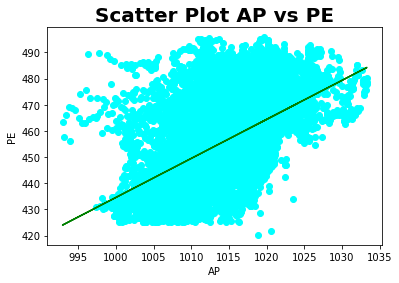

In [591]:
plt.scatter(AP_train, y_train, color='cyan')
plt.plot(AP_train, AP_pred, color='green')
plt.xlabel('AP')
plt.ylabel('PE')
plt.title('Scatter Plot AP vs PE', fontsize = 20, weight = 'bold')
plt.show()

The scatterplot shows positive correlation between AP an PE. It shows the values are spread across each other. Also shows low accuracy of the model.

Boxplot for AP

Text(0.5, 0, 'AP')

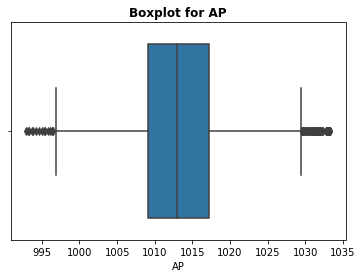

In [592]:
boxplt = sns.boxplot(x = AP_train)
boxplt.set_title("Boxplot for AP", weight = 'bold')
boxplt.set_xlabel('AP')

From this boxplot it is deduced that there are  outliers.


In [593]:
boxplot_stats(AP_train).pop(0)['fliers']

array([ 994.17,  995.88,  995.24,  996.32,  996.55,  996.35,  996.03,
        993.31,  995.45,  995.02,  993.82,  994.6 ,  993.74,  993.11,
        992.89, 1030.46, 1033.25, 1030.18, 1031.1 , 1029.65, 1029.8 ,
       1033.04, 1033.3 , 1032.67, 1033.08, 1031.55, 1029.6 , 1030.3 ,
       1031.5 , 1030.94, 1030.83, 1031.96, 1031.01, 1030.77, 1032.98,
       1032.93, 1031.33, 1030.86, 1030.72, 1033.19, 1031.96, 1030.42,
       1032.86, 1032.77, 1029.63, 1033.09, 1030.82, 1029.99, 1031.8 ,
       1032.08, 1033.14, 1029.54, 1032.88, 1029.7 , 1030.81, 1030.  ,
       1030.2 , 1032.72, 1031.45, 1032.14, 1029.91, 1031.14, 1032.83,
       1032.37, 1032.16, 1031.16, 1030.72, 1029.9 , 1030.1 , 1029.61,
       1031.39, 1031.2 , 1031.27, 1030.38, 1031.97, 1033.29, 1031.58,
       1031.08, 1031.75, 1029.54, 1029.7 , 1031.21, 1031.34, 1030.68,
       1031.71, 1031.21, 1031.32, 1030.61])


 These outliers should be removed for the AP model to fit better.

##### For predictor RH 

In [594]:
RH_train = X_train['RH']
RH_fits, RH_pred, RH_pval, RH_r2 = fit_Predict('RH',RH_train)
print(" Predicted value with respect to the column RH is:\n", RH_pred )

Summary of column:  RH  and PE is:
                             OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1714.
Date:                Tue, 15 Jun 2021   Prob (F-statistic):               0.00
Time:                        00:20:05   Log-Likelihood:                -39933.
No. Observations:                9568   AIC:                         7.987e+04
Df Residuals:                    9566   BIC:                         7.988e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        420

Get p value for the independent variable:
This is done to know whether there is a statistically significant
association between the predictor and the response.
A p-value of less than 0.05 is considered to be statistically significant

In [595]:
RH_pval[1]

0.0

P value is 0.0 which is less than 0.05. Here also the null hypothesis is rejected. Hence RH has a statistically significant association with 'PE'.

 Evaluating the model performance of the regression model

In [596]:
RH_r2

0.15193944023117578

In [597]:
mse = mean_squared_error(y_train, RH_pred)
RH_rmse= math.sqrt(mse)
RH_rmse

15.716209087848236

As compared to AT and V, for the predictor "RH", we got higher RMSE value and lower R2 score . This shows accuracy of model is low as compared to AT and V.

Scatter plot for RH

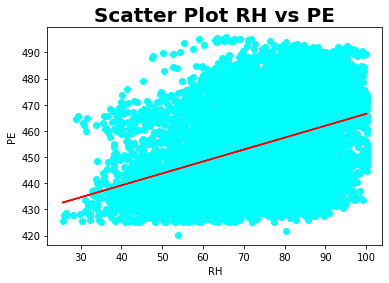

In [598]:
plt.scatter(RH_train, y_train, color='cyan')
plt.plot(RH_train, RH_pred, color='red')
plt.xlabel('RH')
plt.ylabel('PE')
plt.title('Scatter Plot RH vs PE', fontsize = 20, weight = 'bold')
plt.show()

The scatterplot shows positive correlation between AP an PE. It shows the values are spread across each other. Also shows low accuracy of the model.

Boxplot for RH

Text(0.5, 0, 'RH')

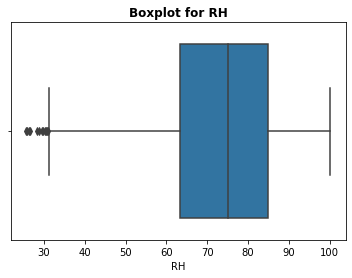

In [599]:
boxplt = sns.boxplot(x = RH_train)
boxplt.set_title("Boxplot for RH", weight = 'bold')
boxplt.set_xlabel('RH')

From this boxplot it is deduced that there are  outliers for  RH . 

In [600]:
boxplot_stats(RH_train).pop(0)['fliers']

array([25.89, 28.16, 29.43, 26.67, 29.86, 30.59, 25.56, 30.83, 28.81,
       26.3 , 30.34, 30.99])

These outliers should be removed for the RH model to fit better.


**SUMMARY**

All the 4 predictors  has a statistically significant association with 'PE'. AT and V has negative correlation with PE . While RH and AP
has positive correlation with PE

## (d) Fit a multiple regression model to predict the response using all of the predictors. Describe your results. For which predictors can we reject the null hypothesis H 0 : β j = 0?

Statsmodel will be use to fit 

In [601]:
X = stat.add_constant(X_train)
multi_model = stat.OLS(y_train, X)
multi_fit = multi_model.fit()

Get the summary of multi regression model

In [602]:
multi_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Tue, 15 Jun 2021   Prob (F-statistic):               0.00
Time:                        00:20:06   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749     46.634      0.000     435.500     473.718
AT            -1.9775      0.015   -129.342      0.000      -2.007      -1.948
V             -0.2339      0.007    -32.122      0.000      -0.248      -0.220
AP             0.0621      0.009      6.564      0.000       0.044       0.081
RH            -0.1581      0.004    -37.918      0.000      -0.166      -0.150
==============================================================================
Omnibus:                      892.002   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4086.777
Skew:                          -0.352   Prob(JB):                         0.00
Kurtosis:                       6.123   Cond. No.                     2.13e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [603]:
multi_pred = multi_fit.predict(X)
multi_pred

0       467.269790
1       444.077366
2       483.562643
3       450.555668
4       471.825499
           ...    
9563    458.630177
9564    472.358625
9565    432.405798
9566    443.036676
9567    449.696037
Length: 9568, dtype: float64

In [604]:
#Get p values of all 4 predictors
for i in range(len(X_train.columns)):
    print("P value for the predictor : ", X_train.columns[i]," in the Multi Regression model is:" ,multi_fit.pvalues[i+1])

P value for the predictor :  AT  in the Multi Regression model is: 0.0
P value for the predictor :  V  in the Multi Regression model is: 4.375305362533725e-215
P value for the predictor :  AP  in the Multi Regression model is: 5.507108852507774e-11
P value for the predictor :  RH  in the Multi Regression model is: 3.104584420167432e-293


P values of all four predictor: AT, V, RH and AP are less than 0.05(considering alpha = 5%). Thus rejecting null hypothesis for all four of them an showing all four independent variables have statistically significant association with 'PE'

In [605]:
# Checking accuracy of multi regression model using R squared and RMSE
multi_r2 = multi_fit.rsquared
print(multi_r2)
mse = mean_squared_error(y_train, multi_pred)
multi_rmse= math.sqrt(mse)
multi_rmse

0.9286960898122536


4.557126016749483

R2 value is very close to 1 and RMSE value is also close to 0. From this we can infer the model fits the data well.

## e) How do your results from 1c compare to your results from 1d? Create a plot displaying the univariate regression coefficients from 1c on the x-axis, and the multiple regression coefficients from 1d on the y-axis. That is, each predictor is displayed as a single point in the plot. Its coefficient in a simple linear regression model is shown on the x-axis, and its coefficient estimate in the multiple linear regression model is shown on the y-axis. 

For comparing the results of linear and multi regression

In [606]:
name = ['AT','V','AP','RH','Multi']
r2_lst = [AT_r2, V_r2, AP_r2, RH_r2, multi_r2]
rmse_lst = [AT_rmse, V_rmse, AP_rmse, RH_rmse, multi_rmse]

In [607]:
# Store R2 and RMSE computed before in data frame
result_df = pd.DataFrame({'Input':name,'R Squared':r2_lst,'Root Mean Square Error':rmse_lst})
result_df

,Input,R Squared,Root Mean Square Error
0,AT,0.898948,5.425099
1,V,0.756518,8.421084
2,AP,0.268769,14.593577
3,RH,0.151939,15.716209
4,Multi,0.928696,4.557126


From the above table , R2 score of multi regression model is hgher than all the linear regression model. Also RMSE of multi regression model 
is lower compared to all the linear regression model. Hence, it can be deduced that multi regression model performance is better than all the linear regression model

In [608]:
# Storing univariate regression coefficients  and the multiple regression coefficients in Data frame
coeff = pd.DataFrame({'Input':name[:4],
        'SLR': [AT_fits.params.values[1],V_fits.params.values[1] , AP_fits.params.values[1],RH_fits.params.values[1]],
        'MLR': multi_fit.params.values[1:]
    })
coeff

,Input,SLR,MLR
0,AT,-2.171320,-1.977513
1,V,-1.168135,-0.233916
2,AP,1.489872,0.062083
3,RH,0.455650,-0.158054


Text(0, 0.5, 'Multiple Regression Coefficients')

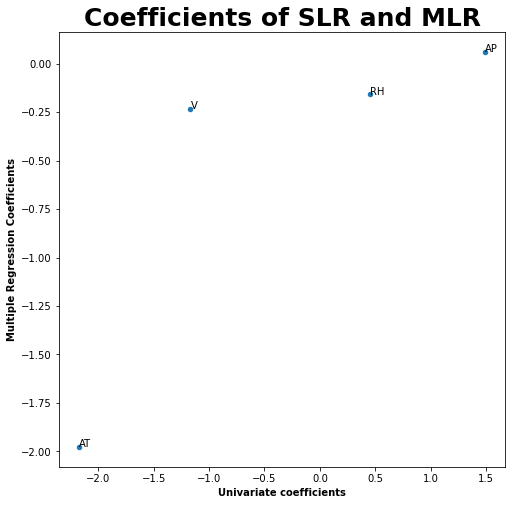

In [609]:
# Scatter plot
ax = coeff.plot(x='SLR',y='MLR',kind='scatter',figsize=(8,8))
coeff[['SLR','MLR','Input']].apply(lambda x: ax.text(*x), axis=1)                
plt.title('Coefficients of SLR and MLR', fontsize = 25, weight = 'bold')
plt.xlabel('Univariate coefficients', weight = 'bold')
plt.ylabel('Multiple Regression Coefficients', weight = 'bold')

On comparing the Univariate coefficient with Multiple regression coefficent, it is evident that for AT and V coefficent value increase in Multiple regression model as compared its value in Simple linear regression value. While for RH and AP the coefficent value decrease in Multiple regression model as compared its value in Simple linear regression value

## (f) Is there evidence of nonlinear association between any of the predictors and the response? To answer this question, for each predictor X , fit a model of the form 2 Y = β 0 + β 1 X + β 2 X 2 + β 3 X 3 + 

In [610]:
# Function to perform a polynomial transform and fit the data
def polyFit(col_name, X = X_train, d = 3, y = y_train ):

    # Perform a polynomial features transform of the dataset
    trans = PolynomialFeatures(degree=3)
    X_poly = trans.fit_transform(X[[col_name]])
    
    # Fit using statsmodel
    X_ols = stat.add_constant(X_poly)
    poly_fit = stat.OLS(y, X_ols).fit()
    print("Summary of column: ", col_name, " and PE is:\n" , poly_fit.summary())
    return poly_fit,  poly_fit.pvalues


In [611]:
AT_fit, AT_poly_pval = polyFit('AT')

Summary of column:  AT  and PE is:
                             OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Tue, 15 Jun 2021   Prob (F-statistic):               0.00
Time:                        00:20:07   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        492

To check nonlinear association between predictor and response, p value need to be first calculated. Here we are taking alpha as 5%.

In [612]:
for i in range(len(AT_poly_pval)):
    print("P value for the predictor AT^", i," is:" ,AT_poly_pval[i])

P value for the predictor AT^ 0  is: 0.0
P value for the predictor AT^ 1  is: 7.898147240158774e-07
P value for the predictor AT^ 2  is: 8.833045326977165e-73
P value for the predictor AT^ 3  is: 3.652184575854443e-110


All the above p values of AT and it's polynomial degree are less than 0.05. Hence null hypothesis of all the terms is rejected. In the above model AT has non-linear association with PE.

In [613]:
V_fit, V_poly_pval = polyFit('V')

Summary of column:  V  and PE is:
                             OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                 1.098e+04
Date:                Tue, 15 Jun 2021   Prob (F-statistic):               0.00
Time:                        00:20:08   Log-Likelihood:                -33585.
No. Observations:                9568   AIC:                         6.718e+04
Df Residuals:                    9564   BIC:                         6.721e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        554.

In [614]:
for i in range(len(V_poly_pval)):
    print("P value for the predictor V^", i," is:" ,V_poly_pval[i])

P value for the predictor V^ 0  is: 0.0
P value for the predictor V^ 1  is: 2.5265890334069744e-05
P value for the predictor V^ 2  is: 0.7684969443856311
P value for the predictor V^ 3  is: 0.013734885927067455


All the above p values of V and it's polynomial degree are less than 0.05 except V^2, where p value is > 0.05.
Hence null hypothesis of all the terms is rejected except V^2. 
But if we observed the p value of V^3, its again  < 0.05. And it has non linear association with response. Thus V still has non-linear association with PE.

In [615]:
AP_fit, AP_poly_pval = polyFit('AP')

Summary of column:  AP  and PE is:
                             OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     1813.
Date:                Tue, 15 Jun 2021   Prob (F-statistic):               0.00
Time:                        00:20:08   Log-Likelihood:                -39184.
No. Observations:                9568   AIC:                         7.837e+04
Df Residuals:                    9565   BIC:                         7.840e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0

In [616]:
for i in range(len(AP_poly_pval)):
    print("P value for the predictor AP^", i," is:" ,AP_poly_pval[i])

P value for the predictor AP^ 0  is: 4.5027336275886946e-17
P value for the predictor AP^ 1  is: 4.502735428523391e-17
P value for the predictor AP^ 2  is: 3.6667048712925936e-17
P value for the predictor AP^ 3  is: 8.264145644669147e-18


All the above p values of AP and it's polynomial degree are less than 0.05. Hence null hypothesis is rejected for all. Therefore AP has non-linear association with PE.

In [617]:
RH_fit, RH_poly_pval = polyFit('RH')

Summary of column:  RH  and PE is:
                             OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     579.2
Date:                Tue, 15 Jun 2021   Prob (F-statistic):               0.00
Time:                        00:20:08   Log-Likelihood:                -39923.
No. Observations:                9568   AIC:                         7.985e+04
Df Residuals:                    9564   BIC:                         7.988e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        468

In [618]:
for i in range(len(RH_poly_pval)):
    print("P value for the predictor RH^", i," is:" ,RH_poly_pval[i])

P value for the predictor RH^ 0  is: 0.0
P value for the predictor RH^ 1  is: 0.0003772509907903602
P value for the predictor RH^ 2  is: 9.39542958957307e-06
P value for the predictor RH^ 3  is: 1.4402785080646408e-05


All the above p values of RH and it's polynomial degree are less than 0.05. Hence null hypothesis is rejected for all the terms. Therefore RH has non-linear association with PE.


**Summary**

From the above p values we conclude there is evidence of nonlinear association between the  predictors: AT, V, AP, RH and the
the response: PE.

## (g) Is there evidence of association of interactions of predictors with the response? To answer this question, run a full linear regression model with all pairwise interaction terms and state whether any interaction terms are statistically significant

We need to analyse the p value inorder to check the  association of interactions of predictors with the response.
Taking alpha  as 5 % i.e 0.05. Using statsmodel model will be fitted.
If P < 0.05 , Null hypothesis of the iteration terms will be rejected.

In [619]:
interact_df = pd.DataFrame({'AT':df['AT'],'V':df['V'],'AP':df['AP'],'RH':df['RH'],'AT*V':df['AT'] * df['V'] ,\
                            'AT*AP':df['AT'] * df['AP'],'AT*RH':df['AT'] * df['RH'],'V*AP': df['V'] * df['AP'],\
                            'V*RH':df['V'] * df['RH'],'AP*RH':df['AP'] * df['RH']})

In [620]:
interact_df

,AT,V,AP,RH,AT*V,AT*AP,AT*RH,V*AP,V*RH,AP*RH
0,14.96,41.76,1024.07,73.17,624.7296,15320.0872,1094.6232,42765.1632,3055.5792,74931.2019
1,25.18,62.96,1020.04,59.08,1585.3328,25684.6072,1487.6344,64221.7184,3719.6768,60263.9632
2,5.11,39.40,1012.16,92.14,201.3340,5172.1376,470.8354,39879.1040,3630.3160,93260.4224
3,20.86,57.32,1010.24,76.64,1195.6952,21073.6064,1598.7104,57906.9568,4393.0048,77424.7936
4,10.82,37.50,1009.23,96.62,405.7500,10919.8686,1045.4284,37846.1250,3623.2500,97511.8026
...,...,...,...,...,...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,827.3385,16883.2665,1515.1500,50386.1569,4521.7900,92274.9100
9564,13.19,39.18,1023.67,66.78,516.7842,13502.2073,880.8282,40107.3906,2616.4404,68360.6826
9565,31.32,74.33,1012.92,36.48,2328.0156,31724.6544,1142.5536,75290.3436,2711.5584,36951.3216
9566,24.48,69.45,1013.86,62.39,1700.1360,24819.2928,1527.3072,70412.5770,4332.9855,63254.7254


In [621]:
X = stat.add_constant(interact_df)
model = stat.OLS(y_train,X)

# Fit using statsmodel
fits = model.fit()
fits.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Tue, 15 Jun 2021   Prob (F-statistic):               0.00
Time:                        00:20:09   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        685.7825     78.640      8.721      0.000     531.631     839.934
AT            -4.3470      2.373     -1.832      0.067      -8.999       0.305
V             -7.6749      1.351     -5.682      0.000     -10.323      -5.027
AP            -0.1524      0.077     -1.983      0.047      -0.303      -0.002
RH             1.5709      0.773      2.031      0.042       0.055       3.087
AT*V           0.0210      0.001     23.338      0.000       0.019       0.023
AT*AP          0.0018      0.002      0.752      0.452      -0.003       0.006
AT*RH         -0.0052      0.001     -6.444      0.000      -0.007      -0.004
V*AP           0.0068      0.001      5.135      0.000       0.004       0.009
V*RH           0.0008      0.000      1.716      0.086      -0.000       0.002
AP*RH         -0.0016      0.001     -2.125      0.034      -0.003      -0.000
==============================================================================
Omnibus:                     1454.609   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9170.848
Skew:                          -0.574   Prob(JB):                         0.00
Kurtosis:                       7.657   Cond. No.                     1.70e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.7e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [622]:
print( " P values of all the terms:\n",fits.pvalues)

 P values of all the terms:
 const     3.231607e-18
AT        6.701873e-02
V         1.371251e-08
AP        4.735732e-02
RH        4.225213e-02
AT*V     3.333358e-117
AT*AP     4.520509e-01
AT*RH     1.216944e-10
V*AP      2.877026e-07
V*RH      8.619366e-02
AP*RH     3.360557e-02
dtype: float64


In [623]:
fits.pvalues[fits.pvalues > 0.05]

AT       0.067019
AT*AP    0.452051
V*RH     0.086194
dtype: float64

We see that the p value for all are less than 0.05 except : 1 V * RH and 2 AT * AP and 3 AT , where p is > 0.05. Hence, these interactions are statistically insignificant. 
All the other interaction terms:  AT * V, AT * RH, V * AP and AP * RH have statistical significant association with the response PE.
Regarding AT, although it's p value is greater than 0.05, I will keep it in the model. As it interaction terms: AT * V, AT * RH are statistically significant and dependent on its parent term AT.

## h) Can you improve your model using possible interaction terms or nonlinear asso- ciations between the predictors and response? Train the regression model on a randomly selected 70% subset of the data with all predictors. Also, run a regres- sion model involving all possible interaction terms and quadratic nonlinearities, and remove insignificant variables using p-values (be careful about interaction terms). Test both models on the remaining points and report your train and test MSEs. 

##### Creating model with all orignal 4 predictors

Splitting Model with all 4 predictor in 7: 3 ratio

In [624]:
# random_stateint: To control the shuffling applied to the data before applying the split.
X_orig, X_test_o, y_orig, y_test_o = train_test_split(X_train, y_train, test_size=0.3, random_state= 850)


In [625]:
X_orig = stat.add_constant(X_orig)
orig_model = stat.OLS(y_orig, X_orig) 

# Fit using statsmodel
orig_fit = orig_model.fit()
orig_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                 2.247e+04
Date:                Tue, 15 Jun 2021   Prob (F-statistic):               0.00
Time:                        00:20:09   Log-Likelihood:                -19587.
No. Observations:                6697   AIC:                         3.918e+04
Df Residuals:                    6692   BIC:                         3.922e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        450.2712     11.636     38.696      0.000     427.461     473.082
AT            -1.9665      0.018   -108.652      0.000      -2.002      -1.931
V             -0.2392      0.009    -27.773      0.000      -0.256      -0.222
AP             0.0664      0.011      5.884      0.000       0.044       0.089
RH            -0.1568      0.005    -31.747      0.000      -0.166      -0.147
==============================================================================
Omnibus:                      455.945   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1660.527
Skew:                          -0.269   Prob(JB):                         0.00
Kurtosis:                       5.379   Cond. No.                     2.15e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [626]:
orig_fit.pvalues

const    8.493038e-296
AT        0.000000e+00
V        9.066603e-161
AP        4.196121e-09
RH       3.709893e-206
dtype: float64

In [627]:
orig_fit.pvalues[orig_fit.pvalues > 0.05]

Series([], dtype: float64)

All the terms are significant.

Predict the response using the above model

In [628]:
pred_orig_train = orig_fit.predict(X_orig)
X_test_o = stat.add_constant(X_test_o)
pred_orig_test = orig_fit.predict(X_test_o)

Find out MSE for the model containing only all 4 original predictor



In [629]:
print("The MSE for the training set containing orignal predictor is:\n",mean_squared_error(y_orig, pred_orig_train))
print("The MSE for the test set  containing orignal predictor is:\n",mean_squared_error(y_test_o, pred_orig_test))

The MSE for the training set containing orignal predictor is:
 20.320441050325627
The MSE for the test set  containing orignal predictor is:
 21.831339695230483


In [630]:
# Creating DF to store all models trains and test MSEs
mse_df = pd.DataFrame(columns=[ 'Train MSE', 'Test MSE'])

# Adding MSE's
mse_df.loc['Orignal LR'] = [mean_squared_error(y_orig, pred_orig_train), mean_squared_error(y_test_o, pred_orig_test) ]


Theoretical  MSE should be 0. But in reality it is not possible. Low MSE indicates  overfitting while d high MSE indicates  underfitting. In the above there is not much difference between the MSEs of train and test data., which doesn't suggest overfitting or underfitting.

##### Creating new df with all  4 original predictor, there interaction terms and quadratic terms

In [631]:
all_interact_df = pd.DataFrame({'AT':df['AT'],'V':df['V'],'AP':df['AP'],'RH':df['RH'],\
                                'AT^2':df['AT']**2,'V^2':df['V']**2, 'AP^2':df['AP']**2,'RH^2':df['RH']**2,\
                            'AT*V':df['AT'] * df['V'] , 'AT*AP':df['AT'] * df['AP'],'AT*RH':df['AT'] * df['RH'],\
                            'V*AP': df['V'] * df['AP'],'V*RH': df['V'] * df['RH'],\
                            'AP*RH':df['AP'] * df['RH'] })

Splitting Model with all  4 original predictor, there interaction terms and quadratic terms

In [632]:
# random_stateint: To control the shuffling applied to the data before applying the split.
X_all, X_test_all, y_all, y_test_all = train_test_split(all_interact_df, y_train, test_size=0.3, random_state= 850)
X_all

,AT,V,AP,RH,AT^2,V^2,AP^2,RH^2,AT*V,AT*AP,AT*RH,V*AP,V*RH,AP*RH
3182,11.70,41.16,1019.58,87.49,136.8900,1694.1456,1.039543e+06,7654.5001,481.5720,11929.0860,1023.6330,41965.9128,3601.0884,89203.0542
9156,12.76,41.48,1014.06,70.34,162.8176,1720.5904,1.028318e+06,4947.7156,529.2848,12939.4056,897.5384,42063.2088,2917.7032,71328.9804
8629,31.96,71.29,1008.39,47.51,1021.4416,5082.2641,1.016850e+06,2257.2001,2278.4284,32228.1444,1518.4196,71888.1231,3386.9879,47908.6089
5717,27.00,73.17,1009.82,64.43,729.0000,5353.8489,1.019736e+06,4151.2249,1975.5900,27265.1400,1739.6100,73888.5294,4714.3431,65062.7026
3020,20.98,60.07,1016.26,67.18,440.1604,3608.4049,1.032784e+06,4513.1524,1260.2686,21321.1348,1409.4364,61046.7382,4035.5026,68272.3468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8639,9.83,41.17,1019.34,72.29,96.6289,1694.9689,1.039054e+06,5225.8441,404.7011,10020.1122,710.6107,41966.2278,2976.1793,73688.0886
6181,9.04,40.11,1023.30,76.32,81.7216,1608.8121,1.047143e+06,5824.7424,362.5944,9250.6320,689.9328,41044.5630,3061.1952,78098.2560
3214,16.84,45.01,1016.14,75.74,283.5856,2025.9001,1.032540e+06,5736.5476,757.9684,17111.7976,1275.4616,45736.4614,3409.0574,76962.4436
7094,15.11,45.01,1014.35,65.03,228.3121,2025.9001,1.028906e+06,4228.9009,680.1011,15326.8285,982.6033,45655.8935,2927.0003,65963.1805


Fitting the model with all 4 original predictor, there interaction terms and quadratic terms using statsmodel

In [633]:
X_all = stat.add_constant(X_all)
all_model = stat.OLS(y_all, X_all)

# Fit using statsmodel
all_fit = all_model.fit()
all_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     7416.
Date:                Tue, 15 Jun 2021   Prob (F-statistic):               0.00
Time:                        00:20:10   Log-Likelihood:                -19131.
No. Observations:                6697   AIC:                         3.829e+04
Df Residuals:                    6682   BIC:                         3.839e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6387.2333   1455.359     -4.389      0.000   -9240.201   -3534.265
AT            -6.3857      3.697     -1.727      0.084     -13.634       0.863
V             -3.8392      1.781     -2.155      0.031      -7.331      -0.347
AP            13.4887      2.821      4.781      0.000       7.958      19.020
RH             3.6694      1.044      3.514      0.000       1.622       5.717
AT^2           0.0149      0.004      4.016      0.000       0.008       0.022
V^2           -0.0006      0.001     -0.586      0.558      -0.002       0.001
AP^2          -0.0066      0.001     -4.815      0.000      -0.009      -0.004
RH^2          -0.0021      0.000     -6.697      0.000      -0.003      -0.001
AT*V           0.0124      0.003      3.818      0.000       0.006       0.019
AT*AP          0.0037      0.004      1.043      0.297      -0.003       0.011
AT*RH         -0.0062      0.002     -3.470      0.001      -0.010      -0.003
V*AP           0.0033      0.002      1.877      0.061      -0.000       0.007
V*RH           0.0007      0.001      0.865      0.387      -0.001       0.002
AP*RH         -0.0034      0.001     -3.325      0.001      -0.005      -0.001
==============================================================================
Omnibus:                      860.914   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4438.516
Skew:                          -0.513   Prob(JB):                         0.00
Kurtosis:                       6.854   Cond. No.                     2.91e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.91e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [634]:
all_fit.pvalues

const    1.157482e-05
AT       8.420574e-02
V        3.116846e-02
AP       1.783799e-06
RH       4.447518e-04
AT^2     5.993305e-05
V^2      5.576702e-01
AP^2     1.507798e-06
RH^2     2.306873e-11
AT*V     1.356156e-04
AT*AP    2.967805e-01
AT*RH    5.237671e-04
V*AP     6.056531e-02
V*RH     3.869797e-01
AP*RH    8.893272e-04
dtype: float64

In [635]:
all_fit.pvalues[all_fit.pvalues > 0.05]

AT       0.084206
V^2      0.557670
AT*AP    0.296780
V*AP     0.060565
V*RH     0.386980
dtype: float64

All the terms whose p values are < 0.05 are statistically significant. While these terms:
AT, V , V^2,  AT * AP,  V * AP,  V * RH     
has p value > than 0.05. Hence all terms have statistically insignificant association with the response.

Predict the response using the above model

In [636]:
pred_all_train = all_fit.predict(X_all)
X_test_all = stat.add_constant(X_test_all)
pred_all_test = all_fit.predict(X_test_all)

Find out MSE

In [637]:

print("The MSE for the training set including all is:\n",mean_squared_error(y_all, pred_all_train))
print("The MSE for the test set including all is:\n",mean_squared_error(y_test_all, pred_all_test))

The MSE for the training set including all is:
 17.735247285682558
The MSE for the test set including all is:
 19.017721163930986


In [638]:
# Adding MSE's
mse_df.loc['All LR'] = [mean_squared_error(y_all, pred_all_train), mean_squared_error(y_test_all, pred_all_test) ]

​
Theoretical MSE should be 0. But in reality it is not possible. Low MSE indicates overfitting while d high MSE indicates underfitting. In the above there is not much difference between the MSEs of train and test data., which doesn't suggest overfitting or underfitting.

##### Creating model with all 4 original predictor, there interaction terms and quadratic terms excluding the insignificant terms

Removing these interaction from data frame :1 V * AP 2 AT * AP 3 V * RH
And adding all quadratic non linearities except V^2.
AT and V will be still retained as their interactions terms are still significant. The dataset will loose meaning if  AT and V is removed as its interaction terms are dependent on its parent terms AT and V.

In [639]:
new_interact_df = pd.DataFrame({'AT':df['AT'],'V':df['V'],'AP':df['AP'],'RH':df['RH'],\
                                'AT^2':df['AT']**2,'AP^2':df['AP']**2,'RH^2':df['RH']**2,\
                            'AT*V':df['AT'] * df['V'] ,'AT*RH':df['AT'] * df['RH'],\
                            'AP*RH':df['AP'] * df['RH']})

Splitting the data with 70% subset of data to predictor and remaining as response

In [640]:
# random_stateint: To control the shuffling applied to the data before applying the split.
X_interact, X_test_i, y_interact, y_test_i = train_test_split(new_interact_df, y_train, test_size=0.3, random_state = 850)

Fitting the model using statsmodel with all 4 original predictor, there interaction terms and quadratic terms excluding the insignificant terms 

In [641]:
X_interact = stat.add_constant(X_interact)
int_model = stat.OLS(y_interact, X_interact)

# Fit using statsmodel
interact_fit = int_model.fit()
interact_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                 1.036e+04
Date:                Tue, 15 Jun 2021   Prob (F-statistic):               0.00
Time:                        00:20:12   Log-Likelihood:                -19141.
No. Observations:                6697   AIC:                         3.830e+04
Df Residuals:                    6686   BIC:                         3.838e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9859.5298   1088.331     -9.059      0.000    -1.2e+04   -7726.053
AT            -2.3861      0.100    -23.831      0.000      -2.582      -2.190
V             -0.4805      0.032    -15.051      0.000      -0.543      -0.418
AP            19.9655      2.152      9.279      0.000      15.748      24.184
RH             5.5597      0.771      7.207      0.000       4.047       7.072
AT^2           0.0154      0.002      6.798      0.000       0.011       0.020
AP^2          -0.0096      0.001     -9.028      0.000      -0.012      -0.008
RH^2          -0.0022      0.000     -7.939      0.000      -0.003      -0.002
AT*V           0.0087      0.001      6.008      0.000       0.006       0.012
AT*RH         -0.0066      0.001     -7.604      0.000      -0.008      -0.005
AP*RH         -0.0052      0.001     -6.934      0.000      -0.007      -0.004
==============================================================================
Omnibus:                      867.530   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4338.098
Skew:                          -0.528   Prob(JB):                         0.00
Kurtosis:                       6.799   Cond. No.                     2.17e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.17e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [642]:
interact_fit.pvalues

const     1.695615e-19
AT       1.521263e-120
V         2.271063e-50
AP        2.267913e-20
RH        6.351215e-13
AT^2      1.148865e-11
AP^2      2.244311e-19
RH^2      2.366071e-15
AT*V      1.981336e-09
AT*RH     3.267156e-14
AP*RH     4.483069e-12
dtype: float64

In [643]:
interact_fit.pvalues[interact_fit.pvalues > 0.05]

Series([], dtype: float64)

All the p values are < 0.05. Hence all terms has statiscally significant association with the response

Predict the response using the above model

In [644]:
pred_inter_train = interact_fit.predict(X_interact)
X_test_i = stat.add_constant(X_test_i)
pred_inter_test = interact_fit.predict(X_test_i)

Find out MSE for the model without containing insignificant term

In [645]:
print("The MSE for the training set including all predictor, interaction, quadratic without insignificant value is:\n",mean_squared_error(y_interact, pred_inter_train))
print("The MSE for the test set including all predictor, interaction, quadratic without insignificant value is:\n",mean_squared_error(y_test_i, pred_inter_test))

The MSE for the training set including all predictor, interaction, quadratic without insignificant value is:
 17.78760459882879
The MSE for the test set including all predictor, interaction, quadratic without insignificant value is:
 19.00884809915467


In [646]:
# Adding MSE's
mse_df.loc['All Significant LR'] = [mean_squared_error(y_interact, pred_inter_train), mean_squared_error(y_test_i, pred_inter_test) ]

Here also the difference between two MSEs is not much. It doesn't indicate overfitting or underfitting.

**Summary**

In [647]:
mse_df

,Train MSE,Test MSE
Orignal LR,20.320441,21.831340
All LR,17.735247,19.017721
All Significant LR,17.787605,19.008848


The above table indicates lowest test data MSE. Thus model containing all 4 original predictor ,their interaction terms and quadratic term without insignificant term has lowest MSEs for both train and test data. Thus, for the power plant dataset we  can improve the linear regression model using possible interaction terms or nonlinear associations between the predictors and response

## (i) KNN Regression: i. Perform k -nearest neighbor regression for this dataset using both normalized and raw features. Find the value of k ∈ { 1 , 2 , . . . , 100 } that gives you the best fit. Plot the train and test errors in terms of 1 /k . 

#### KNN regression using raw features

Splitting data

In [648]:
# random_stateint: To control the shuffling applied to the data before applying the split.
X_knn, X_test_knn, y_knn, y_test_knn = train_test_split(X_train, y_train, test_size=0.3, random_state=850)


In [649]:
# KNN Regression on raw data
knn_raw = KNeighborsRegressor( n_jobs=-1)
error_train = np.array([])
error_test = np.array([])
k_val = np.array([])
for k in range(1, 101):
    k_val = np.append(k_val, k)
    
    # Setting the n neighbours in the interval of 3
    knn_raw.set_params(n_neighbors=k)
    
    # Fit the model
    knn_raw.fit(X_knn, y_knn)
    y_pred_train_r = knn_raw.predict(X_knn)
    y_pred_test_r = knn_raw.predict(X_test_knn)
    error_train = np.append(error_train, (mean_squared_error(y_knn,y_pred_train_r)))
    error_test = np.append(error_test, (mean_squared_error(y_test_knn,y_pred_test_r)))
    


In [650]:
error_raw_df = pd.DataFrame(np.column_stack([list(1/np.array((range(1,101)))), error_train, error_test]), 
                             columns=['1/k', 'train_error', 'test_error'])
error_raw_df

,1/k,train_error,test_error
0,1.000000,0.000000,22.404970
1,0.500000,5.443718,19.006375
2,0.333333,7.634409,17.668699
3,0.250000,9.181990,17.403489
4,0.200000,10.258812,17.255979
...,...,...,...
95,0.010417,21.084329,23.703603
96,0.010309,21.112488,23.735189
97,0.010204,21.146587,23.778052
98,0.010101,21.180153,23.816814


In [651]:
min_train_raw = np.min(error_raw_df.train_error)
print("Least Train error for raw data is ",min_train_raw)
min_k_train = int(error_raw_df[error_raw_df['train_error'] == min_train_raw]['1/k'])
error_raw_df.loc[error_raw_df['train_error'] == np.min(error_raw_df.train_error)]



Least Train error for raw data is  0.0


,1/k,train_error,test_error
0,1.0,0.0,22.40497


In [652]:
min_test_raw = np.min(error_raw_df.test_error)
print("Least Test error for raw data is ",min_test_raw)
min_k_r_te = error_raw_df[error_raw_df['test_error'] == min_test_raw]['1/k']
error_raw_df.loc[error_raw_df['test_error'] == min_test_raw]

Least Test error for raw data is  17.255978629049103


,1/k,train_error,test_error
4,0.2,10.258812,17.255979


In [653]:
# Adding MSE's
mse_df.loc['KNN Raw'] = [error_raw_df.loc[error_raw_df['test_error'] == min_test_raw]['train_error'].values.tolist()[0], min_test_raw ]


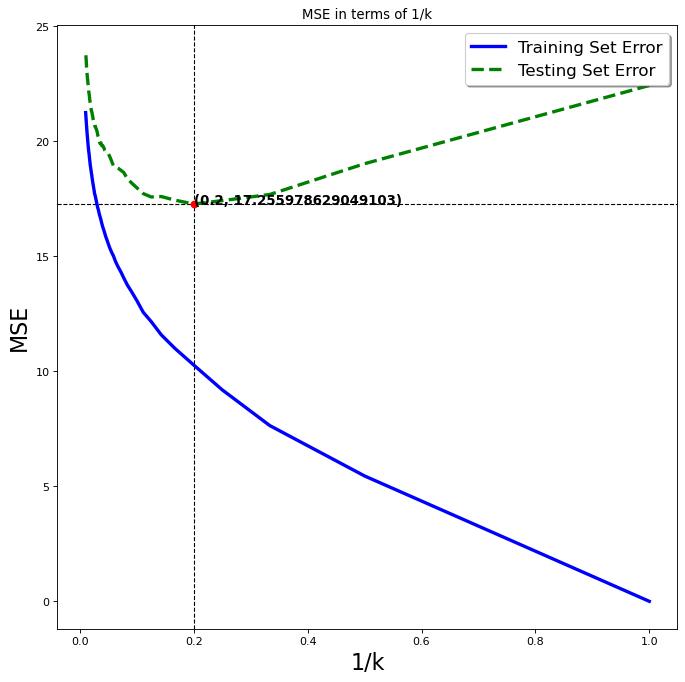

In [654]:
plt.figure(figsize=(10, 10), dpi=80)
axes = plt.gca()

# For drawing vertical and horizontal line across k* and its value
plt.axvline(x = min_k_r_te.values[0], linewidth = 1, linestyle='dashed', color ='black')
plt.axhline(y = min_test_raw, linewidth = 1, linestyle='dashed', color ='black')

# For plotting train and test error
plt.plot( '1/k', 'train_error', data = error_raw_df, color='blue', linewidth=3, label="Training Set Error")
plt.plot( '1/k', 'test_error', data = error_raw_df, color='green', linewidth=3, linestyle='dashed', label="Testing Set Error")

# Plot the point along with annotation
plt.plot(min_k_r_te, min_test_raw,'ro',color ='red') 
ann = plt.annotate("(" +  f'{min_k_r_te.values[0]}' + ", " + f'{min_test_raw}' + ")", xy = (min_k_r_te, min_test_raw),\
                   fontsize = 12, weight = 'bold')
plt.legend(fontsize = 15,fancybox=True, shadow=True)
plt.title('MSE in terms of 1/k', fontsize = 35, weight = 'bold')
plt.xlabel('1/k', fontsize=20)
plt.ylabel('MSE',fontsize=20)
3#plt.legend()
plt.title('MSE in terms of 1/k')

plt.show()

#### KNN regression using normalized features

In [655]:
# define min max scaler
scaler = MinMaxScaler()


In [656]:
# transform data
X_knn_trans, X_test_knn_trans, y_trans_knn, y_trans_test_knn = scaler.fit_transform(X_knn), scaler.fit_transform(X_test_knn),\
scaler.fit_transform(y_knn), scaler.fit_transform(y_test_knn)

In [657]:
normalized_X = scaler.fit_transform(X_train)
X_knn_trans, X_test_knn_trans, y_trans_knn, y_trans_test_knn = train_test_split(normalized_X, y_train, test_size=0.3, random_state=850)


In [658]:
# KNN Regression on normalized data
knn_trans = KNeighborsRegressor( n_jobs = -1)
error_train_trans = np.array([])
error_test_trans = np.array([])
k_val = np.array([])
for k in range(1, 101):
    k_val = np.append(k_val, k)
    
    # Setting the n neighbours in the interval of 3
    knn_trans.set_params(n_neighbors=k)
    
    # Fit the model
    knn_trans.fit(X_knn_trans, y_trans_knn)
    y_pred_train_trans = knn_trans.predict(X_knn_trans)
    y_pred_test_trans = knn_trans.predict(X_test_knn_trans)
    error_train_trans = np.append(error_train_trans, (mean_squared_error(y_trans_knn, y_pred_train_trans)))
    error_test_trans = np.append(error_test_trans, (mean_squared_error(y_trans_test_knn, y_pred_test_trans)))
    


In [659]:
error_nor_df = pd.DataFrame(np.column_stack([list(1/np.array((range(1,101)))), error_train_trans, error_test_trans]), 
                             columns=['1/k', 'train_error_normalized', 'test_error_normalized'])
error_nor_df

,1/k,train_error_normalized,test_error_normalized
0,1.000000,0.000000,20.536953
1,0.500000,4.979783,17.292570
2,0.333333,7.056890,16.028254
3,0.250000,8.330813,15.475571
4,0.200000,9.242018,15.503021
...,...,...,...
95,0.010417,17.832367,19.951019
96,0.010309,17.861965,19.962224
97,0.010204,17.887388,19.967774
98,0.010101,17.913268,19.986671


In [660]:
min_train_nor = np.min(error_nor_df.train_error_normalized)
print("Least Train error for normalized data is ",min_train_nor)
min_k_train_nor = error_raw_df[error_nor_df['train_error_normalized'] == min_train_nor]['1/k']
error_raw_df[error_nor_df['train_error_normalized'] == min_train_nor]

Least Train error for normalized data is  0.0


,1/k,train_error,test_error
0,1.0,0.0,22.40497


In [661]:
min_test_nor = np.min(error_nor_df.test_error_normalized)
print("Least Test error for normalized data is ",min_test_nor)
min_k_te_nor = error_nor_df[error_nor_df['test_error_normalized'] == min_test_nor]['1/k']
error_nor_df[error_nor_df['test_error_normalized'] == min_test_nor]
min_k_te_nor 

Least Test error for normalized data is  15.475570937826545


3    0.25
Name: 1/k, dtype: float64

In [662]:
# Adding MSE's
mse_df.loc['KNN Normalized'] = [error_nor_df[error_nor_df['test_error_normalized'] == min_test_nor]['train_error_normalized'].values.tolist()[0],min_test_nor ]

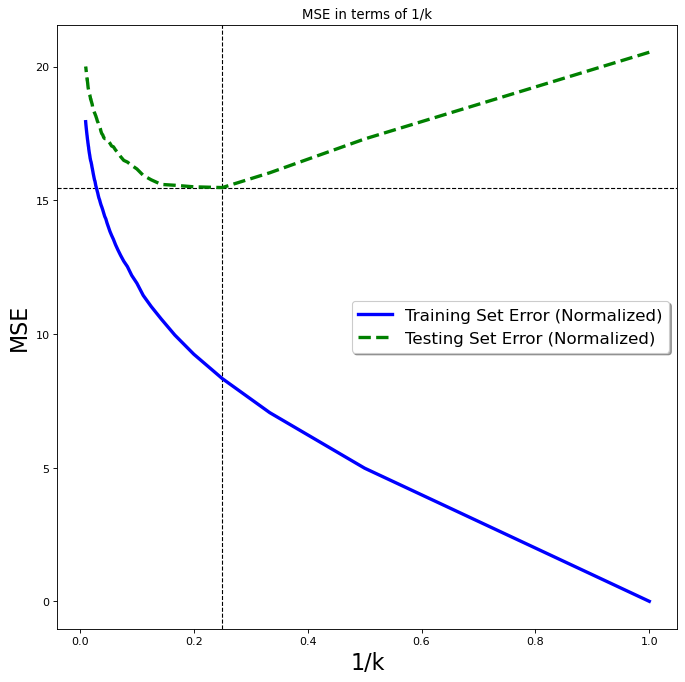

In [663]:
plt.figure(figsize=(10, 10), dpi=80)
axes = plt.gca()

# For drawing vertical and horizontal line across k* and its value
plt.axvline(x = min_k_te_nor.values[0], linewidth = 1, linestyle='dashed', color ='black')
plt.axhline(y = min_test_nor, linewidth = 1, linestyle='dashed', color ='black')

# For plotting train and test error
plt.plot( '1/k', 'train_error_normalized', data = error_nor_df, color='blue', linewidth=3, label="Training Set Error (Normalized)")
plt.plot( '1/k', 'test_error_normalized', data = error_nor_df, color='green', linewidth=3, linestyle='dashed',\
         label="Testing Set Error (Normalized)")

plt.legend(fontsize = 15,fancybox=True, shadow=True)
plt.title('MSE(Normalized) in terms of 1/k', fontsize = 35, weight = 'bold')
plt.xlabel('1/k', fontsize=20)
plt.ylabel('MSE',fontsize=20)
plt.title('MSE in terms of 1/k')

plt.show()

**SUMMARY**

KNN Regression on training data for both raw data and normalized data  decreases with increase in Size of K. WHile on testing data it Decrease with increase in K , but after some value of K, MSE again start increasing.
Here training set is shuffles randomly. random state used above is 850.  On changing the random state k vary between 4 -7
The lowest MSE on test data found is :
normalized MSE = 15.476, k = 4
raw MSE = 17.256, k = 5


## (j) Compare the results of KNN Regression with the linear regression model that has the smallest test error and provide your analysis

Displaying results of train and test MSEs for all the KNN regression and linear regression models

In [664]:
mse_df

,Train MSE,Test MSE
Orignal LR,20.320441,21.831340
All LR,17.735247,19.017721
All Significant LR,17.787605,19.008848
KNN Raw,10.258812,17.255979
KNN Normalized,8.330813,15.475571


From the above table it is evident KKN Regression with Normalized feature data has the least Mean Square Error : 15.475 with K  = 4, among all the above Linear Regression and KNN Regression model.

We can see the MSE for KNN with Raw data is slightly more than KNN with Normalized feature data. While comparing MSE's of Linear data with KNN Regression (Normalized feature) the difference is more.`

The conclusion is KNN regression with Normalized feature data fits the data set best. KNN Regression is a lazy learning algorithm. While working on this data set with KNN regression, execution time for training, fitting and others in jupyter notebook took more time than linear Regression. KNN take time to compute the distance with the all data point. Here in KNN Regression, euclidean distance was used as the metric to measure distance between neighbour. With K = 4 , MSE on test data was found least. Here is this dataset, KNN regression didn't have to face lot of predictor like few Linear Regression models above.
KNN could avoid the curse of dimensionality. Also with normalized data different measurement and ranges of predictors variable comes to common ground without distorting differences in the ranges of values or losing information. Thus KNN regression (normalized feature) performance was increased.

## ISRL Exercise

###  ISLR 2.4.1

 For each of parts (a) through (d), indicate whether we would generally
expect the performance of a flexible statistical learning method to be
better or worse than an inflexible method. Justify your answer.
(a) The sample size n is extremely large, and the number of predictors p is small.
(b) The number of predictors p is extremely large, and the number
of observations n is small.
(c) The relationship between the predictors and response is highly
non-linear.
(d) The variance of the error terms, i.e. σ2 = Var(), is extremely
high.

a) Better. Since sample size is extremely large and predictor is small, flexible method will fit close to data and thus perform better than inflexible

b) Worse. Because of large p and small n, flexible method  will have large variance and will overfit. Thus perform worse than inflexible method.

c) Better. Flexible approach give a better fit for non-linear models. Thus due to more degree of freedom,if the curve is wiggly flexible method fits better than inflexible method..

d)Worse. Flexible approach will easily fit to the noise when variance of the error terms are extremely high as compare to inflexible method. Hence Flexible method performs worse than inflexible method.

### ISLR 2.4.7

The table below provides a training data set containing six observations, three predictors, and one qualitative response variable.
Obs. X1 X2 X3 Y
1 0 3 0 Red
2 2 0 0 Red
3 0 1 3 Red
4 0 1 2 Green
5 −1 0 1 Green
6 1 1 1 Red
Suppose we wish to use this data set to make a prediction for Y when
X1 = X2 = X3 = 0 using K-nearest neighbors.
.54 2. Statistical Learning



*(a) Compute the Euclidean distance between each observation and
the test point, X1 = X2 = X3 = 0*

In [665]:
data = np.array([[0,3,0], [2,0,0], [0,1,3], [0,1,2], [-1,0,1], [1,1,1]])
data

array([[ 0,  3,  0],
       [ 2,  0,  0],
       [ 0,  1,  3],
       [ 0,  1,  2],
       [-1,  0,  1],
       [ 1,  1,  1]])

In [666]:
pred = np.array([0,0,0])
pred

array([0, 0, 0])

In [667]:
dist = np.array([])
for i in range(len(data)):
    point1 = data[i]
    sum_sq = np.array(np.sum(np.square(point1 - pred)))
    dist = np.append(dist, np.sqrt(sum_sq))
print(" Distance between each point and test point is\n",dist)

 Distance between each point and test point is
 [3.         2.         3.16227766 2.23606798 1.41421356 1.73205081]


*(b) What is our prediction with K = 1? Why?*

Green.
When K = 1, we find the 1 nearest neighbour. From the distance array , we find the 5th observation(-1, 0 ,1) is closest(1.414) to the test point(0,0,0). We assign 5th observation's output to test point. Hence test point is predicted green.

*(c) What is our prediction with K = 3? Why?*


Red
When K = 3, we find the 3 nearest neighbour of the test point. From the distance array , we find the 2nd observation(2,0,0), 5th observation(-1, 0 ,1) and 6th observation(1,1,1) are the 3 closest neighbour of the test point(0,0,0). We assign test point label by  majority polling. 2 are red and 1 point is green. Hence test point is predicted red.

*(d) If the Bayes decision boundary in this problem is highly nonlinear, then would we expect the best value for K to be large or
small? Why*

Small.
As K value increases, the decision boundary starts becoming more linear. If boundary is non linear, that means k value is small.

**References**

https://machinelearningmastery.com/how-to-use-correlation-to-understand-the-relationship-between-variables/
https://www.youtube.com/watch?v=L_h7XFUGWAk&ab_channel=DataScienceTutorialsDataScienceTutorials
https://datatofish.com/statsmodels-linear-regression/
https://www.geeksforgeeks.org/python-coefficient-of-determination-r2-score/
https://vitalflux.com/mean-square-error-r-squared-which-one-to-use/
https://medium.com/@cmukesh8688/evaluation-of-linear-regression-model-6e8edbb068f
https://towardsdatascience.com/how-to-use-random-seeds-effectively-54a4cd855a79
https://stackoverflow.com/questions/59431722/labeling-matplotlib-pyplot-scatter-with-pandas-dataframe
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/